# Let’s have a look first!

### Prerequisite: Sentinel Hub account

In order to use Sentinel Hub services you will need a Sentinel Hub account. If you do not have one yet, create one at [Sentinel Hub webpage](https://www.sentinel-hub.com). 

Once you have the account set up, write down your **_instance id_** (alpha-numeric code of length 36) in the next cell.

In [22]:
INSTANCE_ID = ''

### General imports 

In [23]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from base64 import b64encode

## Ipyleaflet map

After installing the ipyleaflet (see https://github.com/ellisonbg/ipyleaflet), lets set it up:

In [25]:
from ipyleaflet import Map, WMSLayer

Lets now center the map somewhere around Kilimanjaro. Luckily, we dont have to be very precise as we can pan and zoom arround :)

In [26]:
m = Map(center=[-3.1, 37.4], zoom=10, layout=dict(width='1000px', height='400px'))
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[-3.1, 37.4], default_tiles=TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']),), layout=Layout(height='400px', width='1000px'), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=10)

When we are happy, we can add our `wms` layer. 

In [27]:
sh_wms_url = 'https://services.sentinel-hub.com/ogc/wms/' + INSTANCE_ID + '?showlogo=0&maxcc=10&time=2017-07-01/2017-08-01'

In [28]:
m.add_layer(WMSLayer(url=sh_wms_url, layers="FALSE_COLOR", tile_size=512))

and control the map programatically as well:

In [29]:
#center coordinates resulting in "nicer" image with Kilimanjaro a bit off-center
m.zoom = 10
m.center=[-3.0020129681723415, 37.643966674804695] 

Map parameters can be read out and reused otherwise:

In [31]:
m.bounds

[(-3.276258782980262, 36.95800781250001),
 (-2.727698295557779, 38.331298828125)]

for instance in `sentinelhub-py` package. This is now where next steps in exploratory analysis starts. 

In [32]:
from sentinelhub.data_request import WmsRequest, WcsRequest
from sentinelhub.constants import MimeType, CustomUrlParam
from sentinelhub.common import BBox, CRS

In [33]:
all_bands_script = 'return [B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12]'

In [34]:
wms_request = WmsRequest(layer='FALSE_COLOR',
                         custom_url_params={CustomUrlParam.EVALSCRIPT: all_bands_script},
                         bbox=BBox(bbox=(m.bounds[0],m.bounds[1]),crs=CRS.WGS84),
                         time=('2017-07-01', '2017-08-01'), 
                         width=950,image_format=MimeType.TIFF_d32f,
                         instance_id=INSTANCE_ID)

In [35]:
image = wms_request.get_data()[0]

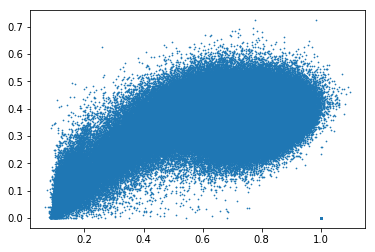

In [36]:
plt.plot(image[:,:,0].ravel(),image[:,:,12].ravel(), linestyle='none', marker='o', markersize=0.7)

In [37]:
import pandas as pd
import seaborn as sns

In [38]:
data = pd.DataFrame(data=np.array([image[:,:,j].ravel() for j in range (0,13)]).transpose(), 
                     index=range(0,len(image[:,:,1].ravel())), 
                     columns = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])

In [49]:
data.sample(n=50).head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12
47134,0.7686,0.7682,0.7374,0.7744,0.7498,0.7635,0.8011,0.7569,0.8136,0.2354,0.0023,0.4734,0.3010
321077,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
349198,0.8508,0.8378,0.7977,0.8320,0.8125,0.8183,0.8520,0.8177,0.8616,0.2909,0.0028,0.5494,0.4047
330082,0.8874,0.8917,0.8630,0.9104,0.8869,0.8961,0.9375,0.9027,0.9511,0.3059,0.0024,0.5262,0.3381
236876,0.1182,0.0991,0.0916,0.0988,0.0951,0.0956,0.0953,0.1066,0.0920,0.0746,0.0042,0.1062,0.0938


In [50]:
sample = data.sample(100)

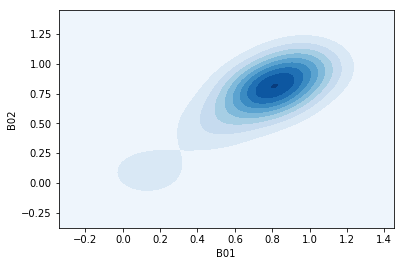

In [51]:
sns.kdeplot(sample.B01, sample.B02, cmap="Blues", shade=True, bw=.15)

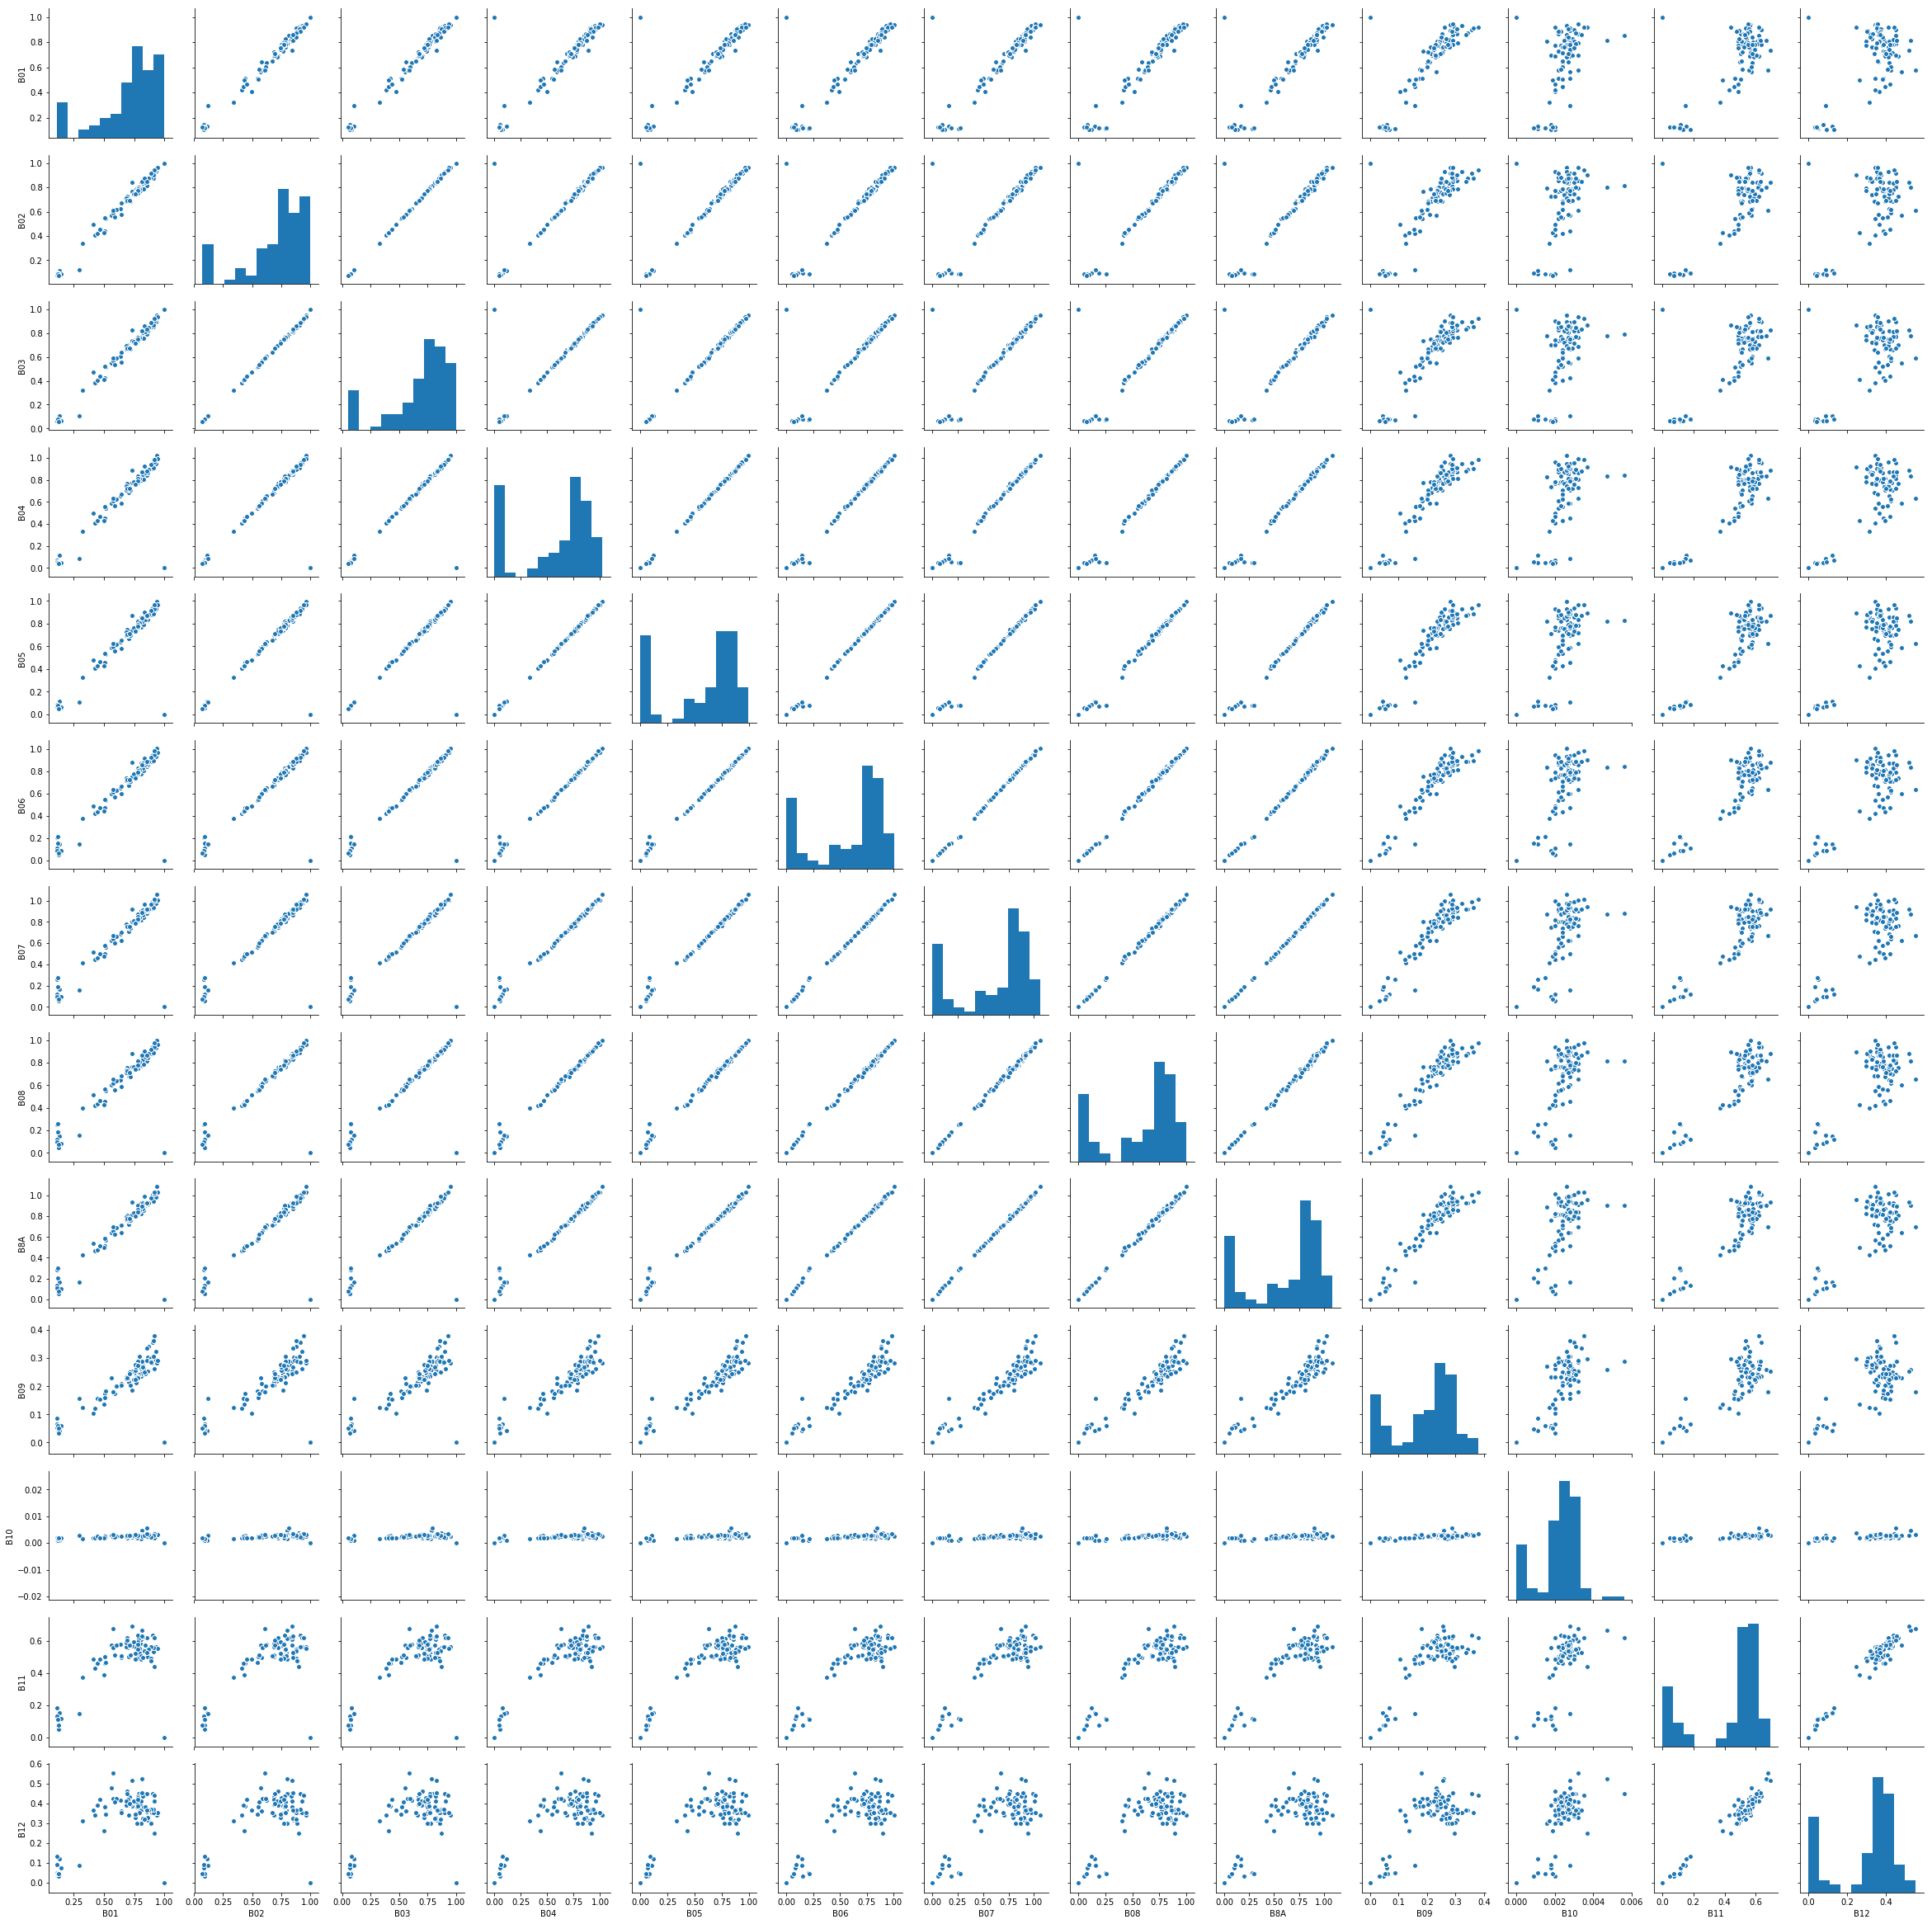

In [52]:
sns.pairplot(sample, kind="scatter")
plt.show()